# Initialisation and imports


In [32]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D, Concatenate, Reshape,GlobalMaxPooling2D, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
from PIL import Image
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
import math
import sys

from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Data Copy

In [4]:

!mkdir /content/data
%cd /content/data/
!ls '/gdrive/My Drive/Colab Notebooks/data' 
!rsync -ah --info=progress2 '/gdrive/My Drive/Colab Notebooks/data/' data/ 

mkdir: cannot create directory ‘/content/data’: File exists
/content/data
0_62   2_1988  3_1274  4_180  6_248	      normalData
1_134  2_240   3_200   5_206  generateCSV.sh  smoothedData
          1.18G  98%    2.24MB/s    0:08:21 (xfr#1474, to-chk=0/1531)


In [0]:
!cat ./data/smoothedData/train.csv

#Data setup

In [50]:

train_df = pandas.read_csv("./data/smoothedData/train.csv")
validate_df = pandas.read_csv("./data/smoothedData/validate.csv")

BS = 64 # Batch size


train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True
        #rotation_range=360
        )

val_datagen = ImageDataGenerator(
        rescale=1./255,
        )


train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='',
        x_col="filename",
        y_col='label',
        target_size=(500, 500),
        batch_size=BS,
        shuffle=True,
        class_mode="raw"
        )

val_generator = train_datagen.flow_from_dataframe(
        dataframe=validate_df,
        directory='',
        x_col="filename",
        y_col='label',
        target_size=(500, 500),
        batch_size=BS,
        shuffle=False,
        class_mode="raw"
        )



Found 473 validated image filenames.
Found 50 validated image filenames.


# Model

In [48]:
VGG16_MODEL = tf.keras.applications.VGG16(input_shape=(None,None,3),include_top=False,weights="imagenet")
RESNET50_MODEL = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(None,None,3), pooling=None, classes=1)#
#MobileNet_MODEL = tf.keras.applications.MobileNet(input_shape=None,include_top=False,weights="imagenet")


model = tf.keras.Sequential()

for layer in VGG16_MODEL.layers:
  model.add(layer)

#for layer in RESNET50_MODEL.layers:
# model.add(layer)

for l in model.layers:
    l.trainable=False
#VGG16_MODEL._layers.pop()
#VGG16_MODEL._layers.pop()
#VGG16_MODEL._layers[0]=Input(shape=(None,None,3))
#VGG16_MODEL.summary()

#model.add(VGG16_MODEL)
#model.add(RESNET50_MODEL)
#model.layers[0].trainable=False
model.add(GlobalAveragePooling2D())
#model.add(Flatten())

#model.add(Dense(4096))

model.add(Dense(1024))

model.add(Dense(1))
model.summary()


optimize = keras.optimizers.RMSprop()
model.compile(optimizer=optimize,
              loss='MSE',
              metrics=['mse']
              )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)  

#Fit

In [51]:
filepath="/gdrive/My Drive/Colab Notebooks/models/weights-improvement-{epoch:02d}-{mse:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='mse', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freg=400)
csv_logger = keras.callbacks.CSVLogger('/gdrive/My Drive/training2.log')
callbacks_list = [checkpoint]
history = model.fit(train_generator,validation_data=val_generator,verbose=1 , epochs=400, steps_per_epoch=None,initial_epoch=0, callbacks=[csv_logger])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 1 steps
Epoch 1/400
8/8 [==============================] - 41s 5s/step - loss: 265582.7380 - mse: 272495.8125 - val_loss: 183074.6406 - val_mse: 183074.6406
Epoch 2/400
8/8 [==============================] - 18s 2s/step - loss: 239213.4370 - mse: 245130.6562 - val_loss: 163573.6094 - val_mse: 163573.6094
Epoch 3/400
8/8 [==============================] - 17s 2s/step - loss: 214138.8614 - mse: 220937.7344 - val_loss: 146152.1562 - val_mse: 146152.1562
Epoch 4/400
8/8 [==============================] - 17s 2s/step - loss: 191400.0332 - mse: 197999.3594 - val_loss: 132806.5156 - val_mse: 132806.5156
Epoch 5/400
8/8 [==============================] - 17s 2s/step - loss: 173125.9778 - mse: 179389.0469 - val_loss: 124135.1094 - val_mse: 124135.1094
Epoch 6/400
8/8 [==============================] - 18s 2s/step - loss: 159662.3140 - mse: 165241.2344 - val_loss: 119026.2109 - val_mse: 119026.2109
Epoch 7/400
8/8 

KeyError: ignored

In [18]:
!nvidia-smi

Mon Feb  3 08:21:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    31W /  70W |   7015MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# History

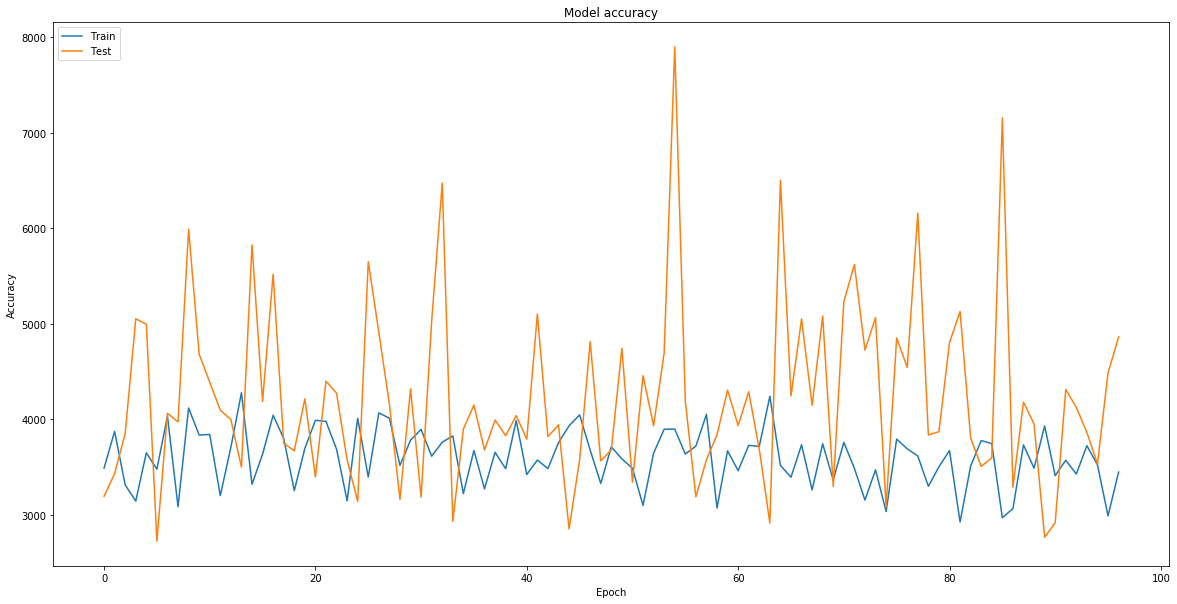

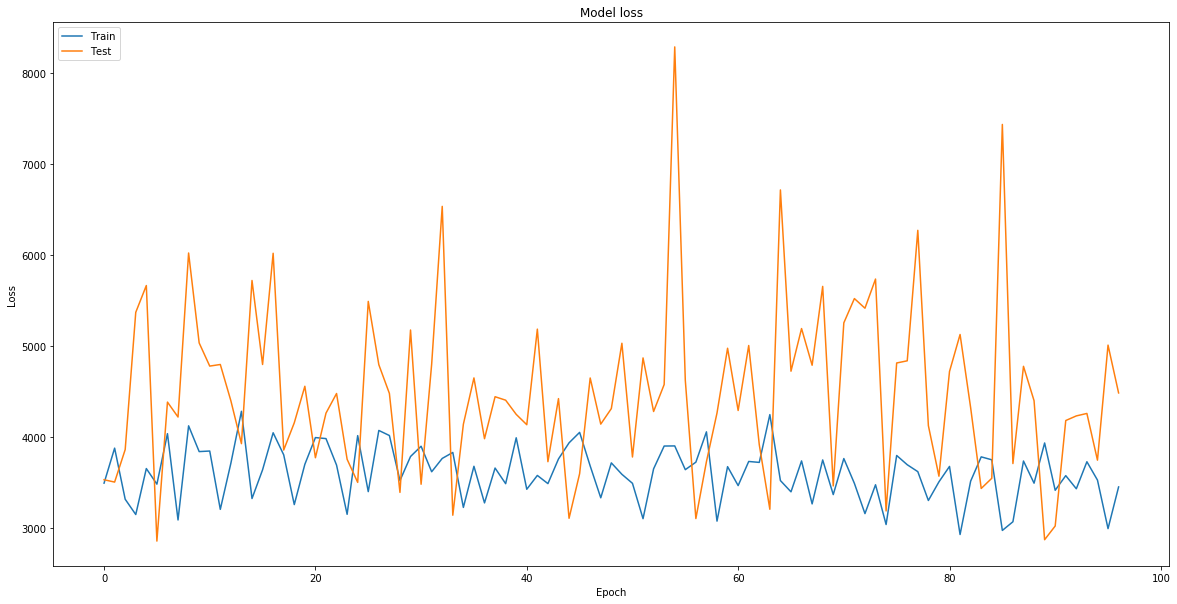

In [52]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

# Save model


In [0]:
model.save('/gdrive/My Drive/Colab Notebooks/.h5')


In [0]:

n = []
numGood=0
numBad=0
for i in range(0,50):
  sys.stdout.write("\r" + str(i))
  x,y= val_generator.next()
  image = x
  label = y[0]
  predict = model.predict(np.expand_dims(image[0], axis=0))[0][0]
  #plt.imshow(image[0])
  #print(label)
  #print(predict)
  #print(abs(label-predict))
  val =abs(1-(label/predict))
  if val < 0.05:
    numGood+=1
  else:
    numBad+=1

  #print(val)
  n.append(val)

print("")
print(numGood)
print(numBad)
print(numGood/numBad)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(n)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('N of test')
plt.show()


40

200 Epochs - 21.95 % < 5%

300 Epochs - 31.23 % < 5%

400 Epochs - 25.00% < 5% - Val dataset not train


In [0]:
x,y= train_generator.next()
predict = VGG16_MODEL.predict(np.expand_dims(x[0], axis=0))[0][0]
for val in predict:
  print(val)

In [0]:
############################ < SHOW GPU MEMORY WHILE TRAINING > ####################################
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os, time
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def worker():
  if SHOW_GPU_USAGE_TIME == 0:
    return;
  while True:
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    time.sleep(SHOW_GPU_USAGE_TIME)
  
import threading
t = threading.Thread(target=worker, name='Monitor')
t.start()
########################### </ SHOW GPU MEMORY WHILE TRAINING > ####################################

In [0]:
!whoami

root


In [0]:
! apt install sshpass ssh
!sed -i "s/\#GatewayPorts no/GatewayPorts yes/g" /etc/ssh/sshd_config 
!sed -i "s/\#PermitRootLogin prohibit-password/PermitRootLogin yes/g" /etc/ssh/sshd_config
!service ssh restart
!passwd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  ncurses-term openssh-server openssh-sftp-server python3-certifi
  python3-chardet python3-idna python3-pkg-resources python3-requests
  python3-six python3-urllib3 ssh-import-id
Suggested packages:
  molly-guard monkeysphere rssh ssh-askpass ufw python3-setuptools
  python3-cryptography python3-openssl python3-socks
The following NEW packages will be installed:
  ncurses-term openssh-server openssh-sftp-server python3-certifi
  python3-chardet python3-idna python3-pkg-resources python3-requests
  python3-six python3-urllib3 ssh ssh-import-id sshpass
0 upgraded, 13 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,164 kB of archives.
After this operation, 7,740 kB of additional disk space will

In [0]:
!cat /etc/ssh/sshd_config

In [0]:
!sshpass -p'Wildfire991' ssh -R :43022:localhost:22 jump@goransson.dk -o StrictHostKeyChecking=no  -p1697

Welcome to Ubuntu 18.04.3 LTS (GNU/Linux 4.15.0-76-generic x86_64)

 * Documentation:  https://help.ubuntu.com
 * Management:     https://landscape.canonical.com
 * Support:        https://ubuntu.com/advantage

  System information as of Wed Jan 29 15:32:24 UTC 2020

  System load:  0.0                Processes:            116
  Usage of /:   12.5% of 31.37GB   Users logged in:      2
  Memory usage: 17%                IP address for ens18: 192.168.10.129
  Swap usage:   0%


0 packages can be updated.
0 updates are security updates.


Last login: Wed Jan 29 15:27:46 2020 from 104.154.204.43
]0;jump@jump: ~jump@jump:~$ ^C
